# ON THE STRUCTURES OF REPRESENTATION FOR THE ROBUSTNESS OF SEMANTIC SEGMENTATION TO INPUT CORRUPTION

## Charles Lehman, Dogancan Temel, Ghassan AlRegib

OLIVES at the Center for Signal and Information Processing,School of Electrical and Computer Engineering,Georgia Institute of Technology, Atlanta, GA, 30332-0250 USA

{charlie.k.lehman,cantemel,alregib}@gatech.edu




## General Imports

In [1]:
import numpy as np
import torch
from functools import partial
import os
from PIL import Image

### Matplotlib

In [2]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def colorize_voc_label(lbl):
    voc_colors =  [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                   [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                   [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                   [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                   [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                   [0, 64, 128]]
    voc_colors = np.array(voc_colors)/255
    voc_cmap = ListedColormap(voc_colors)
    cmap_lbl = voc_cmap(lbl/20)
    cmap_lbl[lbl>20,:3] = (1,1,1)
    return cmap_lbl


def visualize(im, lbl, pred=None):
    im = im.permute(1,2,0).numpy()
    lbl = lbl.squeeze().numpy()
    cols = 3 if pred is not None else 2
    fig, ax = plt.subplots(1,cols)
    im = ((im*MEAN_STD['std']+MEAN_STD['mean'])*255).astype(np.uint8)
    ax[0].imshow(im)
    ax[0].set_title('Image')
    ax[1].imshow(colorize_voc_label(lbl))
    ax[1].set_title('Label')
    ax[0].axis('off')
    ax[1].axis('off')
    if pred is not None:
        pred = pred.squeeze().numpy()
        ax[2].imshow(colorize_voc_label(pred))
        ax[2].set_title('Pred')
        ax[2].axis('off')
    return fig, ax

### Segmentation Transforms

In [3]:
#@title
from torchvision import transforms
import joint_transforms

MEAN_STD = {"mean":(0.485, 0.456, 0.406), "std":(0.229, 0.224, 0.225)}

base_size = 224
crop_size = 224

class ImLblTransform(object):
    def __init__(self, train):
        self.joint_train = []
        im_tran =  [
            transforms.ToTensor(), 
            transforms.Normalize(**MEAN_STD)  
        ]
        
        if train:
            self.joint_train.append(joint_transforms.RandomScaleCrop(base_size, crop_size, fill=255))
            im_tran.insert(0,transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)) 
        else:
            self.joint_train.append(joint_transforms.FixScaleResize(base_size))
            
        self.img_transform = transforms.Compose(im_tran)
            
    def __call__(self, img, lbl):
        for tfm in self.joint_train:
            img, lbl = tfm(img, lbl)
        img = self.img_transform(img)
        lbl = np.array(lbl).astype(np.float32)
        lbl = torch.from_numpy(lbl).float()
        return img, lbl



### VOC2012

1464
1449


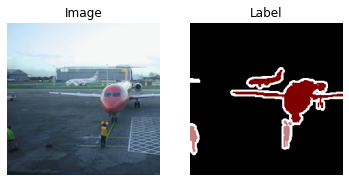

In [4]:
from torchvision.datasets import VOCSegmentation

voc_train = VOCSegmentation(root='/data/datasets/', transforms=ImLblTransform(True))
voc_val = VOCSegmentation(root='/data/datasets/', transforms=ImLblTransform(True), image_set='val')
print(len(voc_train))
print(len(voc_val))
im_,lbl_ = voc_train[0]
fig, ax = visualize(im_,lbl_)


### SBD

5623


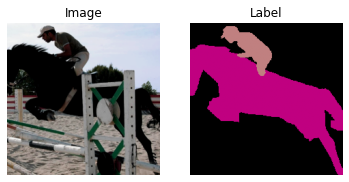

In [5]:
from torchvision.datasets import SBDataset

sbd_train = SBDataset(root='/data/datasets/SBD', image_set='train_noval', 
                      mode='segmentation', transforms=ImLblTransform(True))
print(len(sbd_train))

im_,lbl_ = sbd_train[0]
fig, ax = visualize(im_,lbl_)

### Dataloader



```python
torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, 
                            batch_sampler=None, num_workers=0, collate_fn=None, 
                            pin_memory=False, drop_last=False, timeout=0, 
                            worker_init_fn=None, multiprocessing_context=None
                           )
```



In [6]:
from torch.utils import data

vocsbd_train = data.ConcatDataset([voc_train, sbd_train])

train_iter = data.DataLoader(vocsbd_train, batch_size=20, shuffle=True, 
                             num_workers=12, pin_memory=True, drop_last=True)

STEPS_PER_EPOCH = len(train_iter)

print('Steps per Epoch: {}'.format(STEPS_PER_EPOCH))

val_iter = data.DataLoader(voc_val, batch_size=1, shuffle=False, 
                             num_workers=12, pin_memory=True)

Steps per Epoch: 354


### Corruptions



```python

def corrupt(x, severity=1, corruption_name=None, corruption_number=-1):
    """
    :param x: image to corrupt; a 224x224x3 numpy array in [0, 255]
    :param severity: strength with which to corrupt x; an integer in [0, 5]
    :param corruption_name: specifies which corruption function to call;
    must be one of 'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
                    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
                    'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression',
                    'speckle_noise', 'gaussian_blur', 'spatter', 'saturate';
                    the last four are validation functions
    :param corruption_number: the position of the corruption_name in the above list;
    an integer in [0, 18]; useful for easy looping; 15, 16, 17, 18 are validation corruption numbers
    :return: the image x corrupted by a corruption function at the given severity; same shape as input
    """
```

#### Corruptions to Transform

In [7]:
from imagenet_c import corrupt, corruption_tuple
from functools import partial
from itertools import product as iterprod
from PIL import Image

corr_dict = {}
[corr_dict.update({p.__name__.split('_')[0]:n}) for n,p in enumerate(corruption_tuple[:15])]
print(corr_dict)

class ImLblCorruptTransform(object):
    def __init__(self, severity, corruption_number):
        corrupt_partial = partial(corrupt, severity=severity, corruption_number=corruption_number)
        self.joint_transform = joint_transforms.FixedResize(224)
        self.transform = lambda sz: transforms.Compose(
            [
            np.array,
            corrupt_partial,
            Image.fromarray,
            transforms.Resize(sz),
            transforms.ToTensor(), 
            transforms.Normalize(**MEAN_STD),
            ]
        )
        if severity == 0:
            self.transform = lambda sz: transforms.Compose(
                [
                transforms.ToTensor(), 
                transforms.Normalize(**MEAN_STD)   
                ]
            )
        
            
    def __call__(self, img, lbl):
        img, lbl = self.joint_transform(img,lbl)
        W,H = img.size
        sz = (H,W)
        img = self.transform(sz)(img)
        lbl = np.array(lbl).astype(np.float32)
        lbl = torch.from_numpy(lbl).float()
        return img, lbl


{'gaussian': 0, 'shot': 1, 'impulse': 2, 'defocus': 3, 'glass': 4, 'motion': 5, 'zoom': 6, 'snow': 7, 'frost': 8, 'fog': 9, 'brightness': 10, 'contrast': 11, 'elastic': 12, 'pixelate': 13, 'jpeg': 14}


#### VOC Corruptions 4,5,6,7

Glass, Motion, Zoom and Snow take a long time when run so we can gain efficiencies by preprocessing these at all corruption levels.  To do so use the provided script dump_voc_c.py with the desired corruption number and severity.

motion_blur @ 4


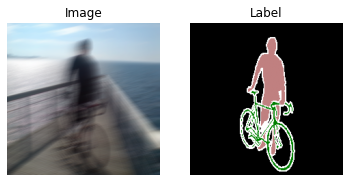

In [8]:
from torchvision import datasets as dsets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
MEAN_STD = {"mean":(0.485, 0.456, 0.406), "std":(0.229, 0.224, 0.225)}

    
class d_4567(Dataset):
    def __init__(self, cn, sv):
        name = corruption_tuple[cn].__name__
        self.name = name
        self.sv = sv
        imgdir = 'VOC-C/{}/{}/'.format(name,sv)
        lbldir = 'VOC-C/lbl/'
        
        self.img_list = [imgdir+f for f in os.listdir(imgdir)]
        self.lbl_list = [lbldir+f for f in os.listdir(lbldir)]
        self.transform = transforms.Compose(
            [
            transforms.ToTensor(), 
            transforms.Normalize(**MEAN_STD)   
            ]
        )
        

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = Image.open(self.img_list[idx]).convert('RGB')
        lbl = Image.open(self.lbl_list[idx])
        img = self.transform(img)
        lbl = np.array(lbl).astype(np.float32)
        lbl = torch.from_numpy(lbl).float()
        return img, lbl
    
    def __str__(self):
        return '{} @ {}'.format(self.name, self.sv)
    
    
d_ = d_4567(5,4)
print(d_)
im,lbl = d_[13]
fig, ax = visualize(im,lbl)
    

#### Visualize Corruptions

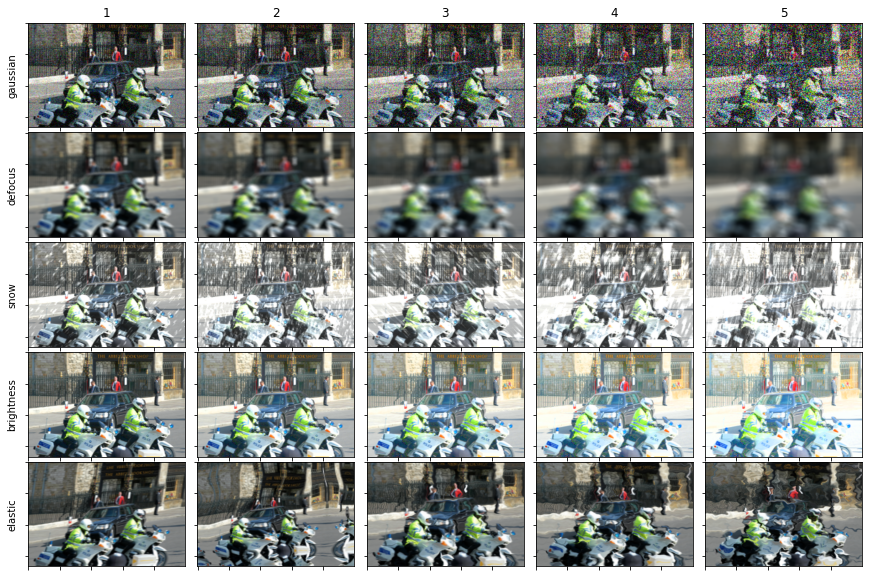

In [9]:
#@title Visualize All Corruptions
index =  687#@param {type:"integer"}
image_set = "val" #@param ["val", "train"]
from imagenet_c import corrupt, corruption_tuple
from PIL import Image
import numpy as np
from matplotlib import gridspec

dataset = VOCSegmentation(root='/data/datasets/', image_set=image_set)
im_,lbl_ = dataset[index]
w, h = im_.size
new_h = 100
new_low_h = 30
new_w = 150
ratio = w/h
s = 10
fig = plt.figure(figsize=(s*ratio, s))
gs1 = gridspec.GridSpec(5,5)
gs1.update(wspace=0.05, hspace=0.05)
orig_size = im_.size
i = 0
for cn in [0,3,7,10,12]:
    for severity in [1,2,3,4,5]:
        corrim = Image.fromarray(corrupt(np.array(im_.resize((224,224),2)), 
                                         severity=severity,
                                         corruption_number=cn)).resize(orig_size)
        #corrim2 = corrim.crop((w//2-new_w//2,new_h,w//2+new_w//2,h-new_low_h))
        ax1 = plt.subplot(gs1[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.grid(False)
        ax1.imshow(corrim)
        if severity==1:
            corname = str(corruption_tuple[cn].__name__).split('_')[0]
            ax1.set_ylabel(corname)
        if cn==0:
            ax1.set_title(severity)
            
        i+=1
    
        
display()


## Metrics

### Running Confusion Matrix

In [10]:
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix as conf_mat 

class RunningConfusionMatrix(object):
    def __init__(self, num_classes, ignore_class=None):
        super(RunningConfusionMatrix, self).__init__()
        self.num_classes = num_classes
        self.ignore_class = ignore_class
        self.reset()

    def __call__(self, prediction, target):
        prediction = prediction.view(-1)
        target = target.view(-1)
        if self.ignore_class is not None:
            prediction = prediction[target!=self.ignore_class]
            target = target[target!=self.ignore_class]
            prediction = prediction[prediction!=self.ignore_class]
            target = target[prediction!=self.ignore_class]
            
        prediction_oh = F.one_hot(prediction, self.num_classes).float()
        target_oh = F.one_hot(target.long(), self.num_classes).float()
        _cm = target_oh.permute(1,0).mm(prediction_oh).long().cpu()
        self.cm += _cm.cpu()
    
    @property
    def acc(self):
        return self.cm.diag()/self.cm.sum(0)
        
    @property
    def iou(self):
        tp = self.cm.diag()
        fp = self.cm.sum(0) - tp
        fn = self.cm.sum(1) - tp
        return tp/(tp+fp+fn)
    
    def reset(self):
        self.cm = torch.zeros(self.num_classes, self.num_classes)


## Experiment

### Trainer

In [11]:
from torchvision import utils
from IPython.display import display, clear_output
from parallel import DataParallelModel, DataParallelCriterion
from tqdm.notebook import tqdm

class SemanticSegmentation(object):
    def __init__(self, config):
        
        self.cuda = config['cuda']
        self.one_hot = config['one_hot']
        self.device = 'cuda' if self.cuda else 'cpu'
        self.confusion_matrix = RunningConfusionMatrix(config['num_classes'], 255)
        
        model = config['model']['class'](**config['model']['kwargs'])
        criterion = config['criterion']['class'](**config['criterion']['kwargs'])
        
        self.optimizer = config['optimizer']['class']([
           {'params':model.backbone.parameters()},
           {'params':model.classifier.parameters(), 'lr':config['optimizer']['kwargs']['lr']*10},
        ],**config['optimizer']['kwargs'])
        self.train_iter = config['train_iter']['class'](**config['train_iter']['kwargs'])
        self.val_iter = config['val_iter']['class'](**config['val_iter']['kwargs'])
        
        
        
        if self.cuda:
            self.model = DataParallelModel(model.to(self.device), device_ids=[0,1])
            self.criterion = DataParallelCriterion(criterion.to(self.device), device_ids=[0,1])
        else:
            self.model = model
            self.criterion = criterion
        
        self.steps = 0
        self.epoch_n = 0
        self.config = config
    
    def evaluator(self):
        pass
    
    def step(self, input, target, oh_target):
        name = 'Train' if self.model.training else 'Val'
        output = self.model(input)
        pred = torch.cat(output,0).argmax(1)
        self.confusion_matrix(pred, target)
        iou = self.confusion_matrix.iou
        miou = iou[~torch.isnan(iou)].mean()
        if self.model.training:
            self.confusion_matrix.reset()
            loss = self.criterion(output, oh_target if self.one_hot else target.long()).mean()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.steps += 1
            _loss = loss.item()
        else:
            _loss =  0
        self.tbar.set_description('[{} - {}] Loss: {:.3f}, mIOU: {:.3f}'.format(self.epoch_n, name, _loss, miou))
        return pred.cpu()
    
    def epoch(self, data_iter):
        self.tbar = tqdm(data_iter)
        for input, target in self.tbar:
            _target = target.clone()
            _target[target==255] = 0
            oh_target = nn.functional.one_hot(_target.long(),21).permute(0,3,1,2).float()
            pred = self.step(input.to(self.device), 
                               target.to(self.device), 
                               oh_target.to(self.device))

    def train(self, num_epochs, lr_sched=True):
        if lr_sched:
            poly = lambda step: (1 - step/num_epochs)**0.9
        else:
            poly = lambda step: 1 
        self.lr_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=poly)
        for n in range(num_epochs):
            self.epoch_n = n
            self.model.train()
            self.epoch(self.train_iter)
            if self.config['validate_while_train']:
                self.validate()
            self.lr_scheduler.step()
            
    def validate(self):
        self.confusion_matrix.reset()
        self.model.eval()
        self.epoch(self.val_iter)
    
    def visualize(self, input, target, pred):
        fig, ax = visualize(input[0], target[0], pred[0])

## Models

### DeepLabV3+

In [12]:
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models import resnet50
from torchvision.models._utils import IntermediateLayerGetter
from torch import nn

class DLv3_ResNet50(nn.Module):
    def __init__(self, num_classes=21):
        super(DLv3_ResNet50, self).__init__()
        model = deeplabv3_resnet50(num_classes = num_classes)
        backbone = resnet50(pretrained=True, replace_stride_with_dilation=[False, True, True])
        return_layers = {'layer4': 'out'}
        model.backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.backbone = model.backbone
        self.classifier = model.classifier
    
    def forward(self,x):
        input_shape = x.shape[-2:]
        features = self.backbone(x)
        x = features["out"]
        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x
    
    
ns_config = {
    'num_classes':21,
    'one_hot':False,
    'cuda':True,
    'validate_while_train':True,
    'model':{
        'class':DLv3_ResNet50,
        'kwargs':{
            'num_classes':21,
        },
    },
    'criterion':{
        'class':nn.CrossEntropyLoss,
        'kwargs':{
            'ignore_index':255,
        },
    },
    'optimizer':{
        'class': torch.optim.SGD,
        'kwargs':{
            'lr':0.01,
            'momentum':0.9,
            'weight_decay':5e-5,
            'nesterov':False
        },
    },
    'train_iter':{
        'class':data.DataLoader,
        'kwargs':{
            'dataset':vocsbd_train,
            'batch_size':30,
            'shuffle':True,
            'num_workers':12,
            'pin_memory':True,
            'drop_last':True,
        }
    },
    'val_iter':{
        'class':data.DataLoader,
        'kwargs':{
            'dataset':voc_val,
            'batch_size':1,
            'shuffle':False,
            'num_workers':1,
            'pin_memory':False,
            'drop_last':False,
        }
    }
}

pth = 'data/DLv3_ResNet50.pth'
if  os.path.isfile(pth):
    no_scribe_model = ns_config['model']['class'](**ns_config['model']['kwargs'])
    no_scribe_model.load_state_dict(torch.load(pth))
else:
    no_scribe_experiment = SemanticSegmentation(ns_config)
    no_scribe_experiment.train(50, True)
    no_scribe_model = no_scribe_experiment.model.module
    torch.save(no_scribe_model.state_dict(), pth)
    no_scribe_experiment.validate()


### DeepLabV3+IBE

In [13]:
class DLv3_ResNet50_IBE(DLv3_ResNet50):
    def __init__(self, num_classes=20):
        super(DLv3_ResNet50_IBE, self).__init__(num_classes=num_classes)
    
    def forward(self,x):
        input_shape = x.shape[-2:]
        features = self.backbone(x)
        x = features["out"]
        x = self.classifier(x)
        x = torch.cat([-torch.logsumexp(x,1, keepdim=True),x],1)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x
    
i_config = {
    'num_classes':21,
    'one_hot':False,
    'cuda':True,
    'validate_while_train':True,
    'model':{
        'class':DLv3_ResNet50_IBE,
        'kwargs':{
            'num_classes':20,
        },
    },
    'criterion':{
        'class':nn.CrossEntropyLoss,
        'kwargs':{
            'ignore_index':255,
        },
    },
    'optimizer':{
        'class': torch.optim.SGD,
        'kwargs':{
            'lr':0.01,
            'momentum':0.9,
            'weight_decay':5e-5,
            'nesterov':False
        }
    },
    'train_iter':{
        'class':data.DataLoader,
        'kwargs':{
            'dataset':vocsbd_train,
            'batch_size':30,
            'shuffle':True,
            'num_workers':12,
            'pin_memory':True,
            'drop_last':True,
        }
    },
    'val_iter':{
        'class':data.DataLoader,
        'kwargs':{
            'dataset':voc_val,
            'batch_size':5,
            'shuffle':False,
            'num_workers':1,
            'pin_memory':False,
            'drop_last':False,
        }
    }
}

pth = 'data/DLv3_IBE.pth'
if  os.path.isfile(pth):
    ibe_model = i_config['model']['class'](**i_config['model']['kwargs'])
    ibe_model.load_state_dict(torch.load(pth))
else:
    ibe_experiment = SemanticSegmentation(i_config)
    ibe_experiment.train(50, True)
    ibe_model = ibe_experiment.model.module
    torch.save(ibe_model.state_dict(), pth)
    ibe_experiment.validate()
    
    

### DeepLabV3+ScrIBE

In [14]:
class DLv3_ResNet50_SCrIBE(DLv3_ResNet50):
    def __init__(self, num_classes=20):
        super(DLv3_ResNet50_SCrIBE, self).__init__(num_classes=num_classes)
    
    def forward(self,x):
        input_shape = x.shape[-2:]
        _x = self.backbone(x)
        x = self.classifier(_x["out"])
        x = torch.cat([-torch.logsumexp(x,1, keepdim=True),x],1)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x
    
    
s_config = {
    'num_classes':21,
    'one_hot':True,
    'cuda':True,
    'validate_while_train':True,
    'model':{
        'class':DLv3_ResNet50_SCrIBE,
        'kwargs':{
            'num_classes':20,
        },
    },
    'criterion':{
        'class':nn.BCEWithLogitsLoss,
        'kwargs':{
        },
    },
    'optimizer':{
        'class': torch.optim.SGD,
        'kwargs':{
            'lr':0.01,
            'momentum':0.9,
            'weight_decay':5e-5,
            'nesterov':False
        }
    },
    'train_iter':{
        'class':data.DataLoader,
        'kwargs':{
            'dataset':vocsbd_train,
            'batch_size':30,
            'shuffle':True,
            'num_workers':12,
            'pin_memory':True,
            'drop_last':True,
        }
    },
    'val_iter':{
        'class':data.DataLoader,
        'kwargs':{
            'dataset':voc_val,
            'batch_size':1,
            'shuffle':False,
            'num_workers':1,
            'pin_memory':False,
            'drop_last':False,
        }
    }
}

pth = 'data/DLv3_SCrIBE.pth'
if  os.path.isfile(pth):
    scribe_model = s_config['model']['class'](**s_config['model']['kwargs'])
    scribe_model.load_state_dict(torch.load(pth))
else:
    scribe_experiment = SemanticSegmentation(s_config)
    scribe_experiment.train(50, True)
    scribe_model = scribe_experiment.model.module
    torch.save(scribe_model.state_dict(), pth)
    scribe_experiment.validate()
    

## Representation Metrics

### Running Logit Tracker

In [15]:

class RunningLogitTracker(object):
    def __init__(self, num_classes, ignore_class=None):
        super(RunningLogitTracker, self).__init__()
        self.num_classes = num_classes
        self.ignore_class = ignore_class
        self.reset()

    def __call__(self, output):
        output = output.permute(0,2,3,1).reshape(-1,self.num_classes)
        _pred = output.argmax(1)
        for n in range(self.num_classes):
            x = output[_pred==n,:].detach()
            self.counts[n] += x.size(0)
            self.sums[n] += x.sum(0).cpu()
            self.sumsqs[n] += x.permute(1,0).mm(x).cpu()
        
    def dist(self,x,y):
        return (x-y).pow(2).sum().sqrt()
    
    @property
    def dm(self):
        _dm = torch.zeros(self.num_classes, self.num_classes)
        mn = self.mean
        for i in range(0,self.num_classes):
            for j in range(i,self.num_classes):
                _dm[i,j] = self.dist(mn[i], mn[j])
                _dm[j,i] = _dm[i,j]
        return _dm
        
    @property
    def mean(self):
        out = self.sums/self.counts.unsqueeze(1)
        out[out!=out] = 0
        return out
    
    @property
    def cov(self):
        covs = []
        for n in range(self.num_classes):
            mn = self.mean[n].unsqueeze(0)
            sq = self.sumsqs[n]
            _cov = (sq - mn.permute(1,0).mm(mn))/self.counts[n]
            _cov[_cov!=_cov] = 0
            covs.append(_cov)
        return torch.stack(covs,0)
    
    @property
    def cor(self):
        covs = self.cov
        cors = []
        for n in range(self.num_classes):
            S = covs[n]
            Dinv = torch.inverse(S.diag().diag().sqrt())
            R = Dinv.mm(S).mm(Dinv)
            cors.append(R)
        return torch.stack(cors,0)
    
    def reset(self):
        self.counts = torch.zeros(self.num_classes) 
        self.sums = torch.zeros(self.num_classes, self.num_classes)
        self.sumsqs = torch.zeros(self.num_classes, self.num_classes, self.num_classes)


### Run All

In [16]:
import torch
import gc
import pandas as pd


batch = 20

nm = 'data/DistCombined.pkl'

scribe_model = scribe_model.to(0)
ibe_model = ibe_model.to(0)
no_scribe_model = no_scribe_model.to(1)

scribe_model.eval()
ibe_model.eval()
no_scribe_model.eval()

try:
    dist_df = pd.read_pickle(nm).drop_duplicates()
    lgst_cn = dist_df['corruption_number'].max()
    lgst_sv = dist_df[dist_df['corruption_number']==lgst_cn]['Severity'].max()
    print('Restarting from {}@{}'.format(lgst_cn, lgst_sv))
    dist_data = dist_df.to_dict('records')
    flag = False 
except:
    print('New Run!')
    lgst_cn = 0
    lgst_sv = 0
    dist_data = []
    flag = False 


for cn in range(lgst_cn,15):
    corruption_name = corruption_tuple[cn].__name__
    for sv in range(6):
        if sv==0 and flag:
            print('Case 1: Skipping {}@{}'.format(cn, sv))
            continue
        if cn != lgst_cn: 
            lgst_sv=-1
        if sv < lgst_sv: 
            print('Case 2: Skipping {}@{}'.format(cn, sv))
            continue
        s_cm = RunningConfusionMatrix(21, 255)
        i_cm = RunningConfusionMatrix(21, 255)
        n_cm = RunningConfusionMatrix(21, 255)
        s_lt = RunningLogitTracker(21, 255)
        i_lt = RunningLogitTracker(21, 255)
        n_lt = RunningLogitTracker(21, 255)

        if cn in [4,5,6,7]:
            corr_val = d_4567(cn,sv)
        else:
            corr_val = VOCSegmentation(root='/data/datasets/', 
                                        transforms=ImLblCorruptTransform(sv,cn), 
                                        image_set='val')

        corr_iter = data.DataLoader(corr_val, batch_size=batch, shuffle=False, num_workers=1, pin_memory=True)
        pbar = tqdm(corr_iter, position=0, leave=True)
        for im,lbl in pbar:
            s_output = scribe_model(im.to(0))
            i_output = ibe_model(im.to(0))
            n_output = no_scribe_model(im.to(1))

            s_pred = s_output.argmax(1)
            i_pred = i_output.argmax(1)
            n_pred = n_output.argmax(1)

            s_cm(s_pred, lbl.to(0))
            i_cm(i_pred, lbl.to(0))
            n_cm(n_pred, lbl.to(1))

            s_iou = s_cm.iou
            s_miou = s_iou[~torch.isnan(s_iou)].mean()
            i_iou = i_cm.iou
            i_miou = i_iou[~torch.isnan(i_iou)].mean()
            n_iou = n_cm.iou
            n_miou = n_iou[~torch.isnan(n_iou)].mean()

            s_lt(s_output)
            i_lt(i_output)
            n_lt(n_output)


            pbar.set_description('{}@{} S/I/B: {:.3f} / {:.3f} / {:.3f}'.format(cn, sv, s_miou,i_miou,n_miou))
            
        s_mn = s_lt.mean.numpy()
        i_mn = i_lt.mean.numpy()
        n_mn = n_lt.mean.numpy()

        s_r = np.mean(np.diagonal(s_mn)[1:]-s_mn[1:,0])
        i_r = np.mean(np.diagonal(i_mn)[1:]-i_mn[1:,0])
        n_r = np.mean(np.diagonal(n_mn)[1:]-n_mn[1:,0])
        dist_data.append(
                    {
                        'Model':'ScrIBE',
                        'Corruption':corruption_name,
                        'corruption_number':cn,
                        'Severity':sv,
                        'mIOU':s_miou.item(),
                        'Distance':s_r
                    }
        )
        dist_data.append(
                    {
                        'Model':'IBE',
                        'Corruption':corruption_name,
                        'corruption_number':cn,
                        'Severity':sv,
                        'mIOU':i_miou.item(),
                        'Distance':i_r
                    }
        )
        dist_data.append(
                    {
                        'Model':'Baseline',
                        'Corruption':corruption_name,
                        'corruption_number':cn,
                        'Severity':sv,
                        'mIOU':n_miou.item(),
                        'Distance':n_r
                    }
        )

        dist_df = pd.DataFrame(dist_data)
        dist_df.to_pickle(nm)
        flag = True

Restarting from 14@5
Case 2: Skipping 14@0
Case 2: Skipping 14@1
Case 2: Skipping 14@2
Case 2: Skipping 14@3
Case 2: Skipping 14@4


### Run One

In [17]:
import torch
import gc
import pandas as pd

torch.cuda.empty_cache()

def run_one(scribe_model, ibe_model, no_scribe_model):
    scribe_model = scribe_model.to(0)
    ibe_model = ibe_model.to(0)
    no_scribe_model = no_scribe_model.to(1)
    scribe_model.eval()
    ibe_model.eval()
    no_scribe_model.eval()

    s_cm = RunningConfusionMatrix(21, 255)
    i_cm = RunningConfusionMatrix(21, 255)
    n_cm = RunningConfusionMatrix(21, 255)
    s_lt = RunningLogitTracker(21, 255)
    i_lt = RunningLogitTracker(21, 255)
    n_lt = RunningLogitTracker(21, 255)

    corr_val = VOCSegmentation(root='/data/datasets/', 
                              transforms=ImLblTransform(False), 
                              image_set='val')

    corr_iter = data.DataLoader(corr_val, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)
    pbar = tqdm(corr_iter, position=0, leave=True)
    for im,lbl in pbar:
        s_output = scribe_model(im.to(0))
        i_output = ibe_model(im.to(0))
        n_output = no_scribe_model(im.to(1))

        s_pred = s_output.argmax(1)
        i_pred = i_output.argmax(1)
        n_pred = n_output.argmax(1)

        s_cm(s_pred, lbl.to(0))
        i_cm(i_pred, lbl.to(0))
        n_cm(n_pred, lbl.to(1))

        s_iou = s_cm.iou
        s_miou = s_iou[~torch.isnan(s_iou)].mean()
        i_iou = i_cm.iou
        i_miou = i_iou[~torch.isnan(i_iou)].mean()
        n_iou = n_cm.iou
        n_miou = n_iou[~torch.isnan(n_iou)].mean()

        s_lt(s_output)
        i_lt(i_output)
        n_lt(n_output)


        pbar.set_description('S/I/B: {:.3f} / {:.3f} / {:.3f}'.format(s_miou,i_miou,n_miou))
    return s_lt, i_lt, n_lt

s_lt, i_lt, n_lt = run_one(scribe_model, ibe_model, no_scribe_model)



<AxesSubplot:xlabel='Component', ylabel='Explained Variance'>

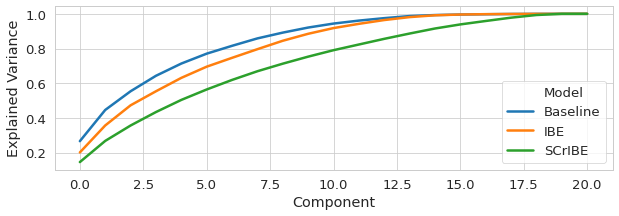

In [18]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

pca_data = []

pca = PCA(n_components=21)
pca.fit(s_lt.mean)
s_cs = pca.explained_variance_ratio_.cumsum()
pca = PCA(n_components=21)
pca.fit(i_lt.mean)
i_cs = pca.explained_variance_ratio_.cumsum()
pca = PCA(n_components=21)
pca.fit(n_lt.mean)
n_cs = pca.explained_variance_ratio_.cumsum()
for m, p in zip(['SCrIBE', 'IBE', 'Baseline'],[s_cs, i_cs, n_cs]):
    for x,y in enumerate(p):
        _d = {
            'Model': m,
            'Variant': 'Single',
            'Component':x,
            'Explained Variance':y
        }
        pca_data.append(_d)


pca_df = pd.DataFrame(pca_data)

fig, ax = plt.subplots(figsize=[10,3])
sns.lineplot(ax=ax,data=pca_df, x='Component', y='Explained Variance', hue='Model', hue_order =['Baseline', 'IBE', 'SCrIBE'])

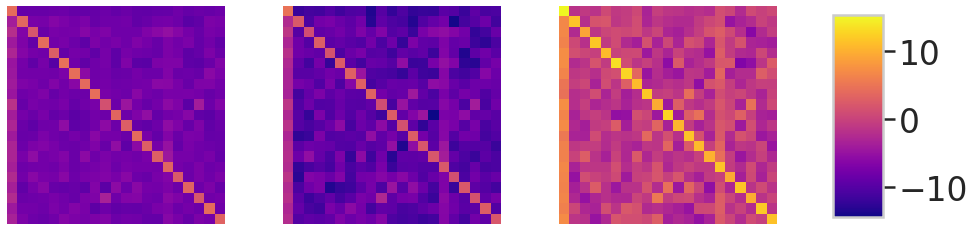

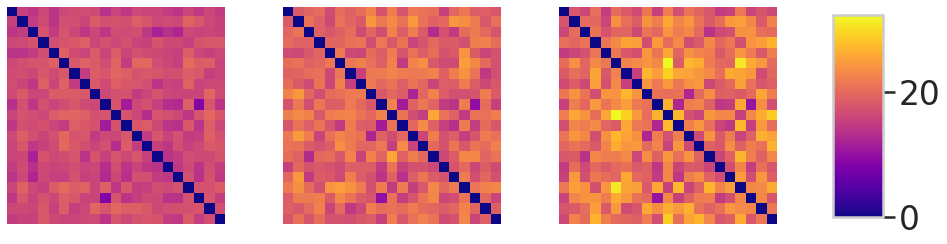

-0.99993795 1.0000002


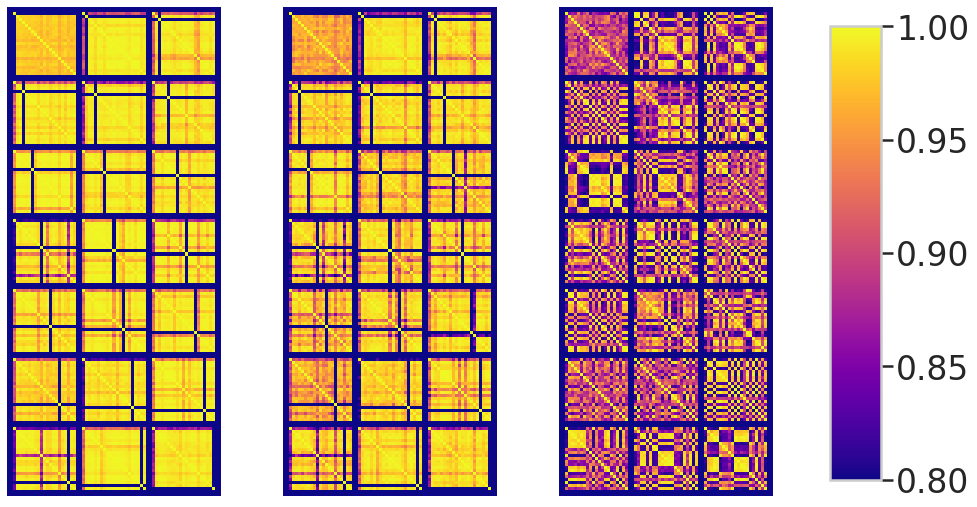

In [19]:
from torchvision.utils import make_grid
from matplotlib.colors import LogNorm
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set(style="whitegrid")
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig, ax = plt.subplots(1,3, figsize=(14,4))
s_mn = s_lt.mean.numpy()
i_mn = i_lt.mean.numpy()
n_mn = n_lt.mean.numpy()

s_r = np.diagonal(s_mn)-s_mn[:,0]
i_r = np.diagonal(i_mn)-i_mn[:,0]
n_r = np.diagonal(n_mn)-n_mn[:,0]


_mx = max([s_mn[s_mn!=-255].max(), i_mn[i_mn!=-255].max(), n_mn[n_mn!=-255].max()])
_mn = min([s_mn[s_mn!=-255].min(), i_mn[i_mn!=-255].min(), n_mn[n_mn!=-255].min()])

im = ax[0].imshow(s_mn, vmin=_mn, vmax=_mx, cmap='plasma')
ax[1].imshow(i_mn, vmin=_mn, vmax=_mx, cmap='plasma')
ax[2].imshow(n_mn, vmin=_mn, vmax=_mx, cmap='plasma')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

fig, ax = plt.subplots(1,3, figsize=(14,4))
s_mn = s_lt.dm.numpy()
i_mn = i_lt.dm.numpy()
n_mn = n_lt.dm.numpy()

_mx = max([s_mn[s_mn!=-255].max(), i_mn[i_mn!=-255].max(), n_mn[n_mn!=-255].max()])
_mn = min([s_mn[s_mn!=-255].min(), i_mn[i_mn!=-255].min(), n_mn[n_mn!=-255].min()])

im = ax[0].imshow(s_mn, vmin=_mn, vmax=_mx, cmap='plasma')
ax[1].imshow(i_mn, vmin=_mn, vmax=_mx, cmap='plasma')
ax[2].imshow(n_mn, vmin=_mn, vmax=_mx, cmap='plasma')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

s_im = make_grid(s_lt.cor.unsqueeze(1), nrow=3, padding=2, pad_value=-255)[0,:,:].numpy()
i_im = make_grid(i_lt.cor.unsqueeze(1), nrow=3, padding=2, pad_value=-255)[0,:,:].numpy()
n_im = make_grid(n_lt.cor.unsqueeze(1), nrow=3, padding=2, pad_value=-255)[0,:,:].numpy()

_mx = max([s_im[s_im!=-255].max(), n_im[n_im!=-255].max()])
_mn = min([s_im[s_im!=-255].min(), n_im[n_im!=-255].min()])

print(_mn,_mx)

fig, ax = plt.subplots(1,3, figsize=(14,9))
im = ax[0].imshow(s_im, vmin=0.8, vmax=_mx, cmap='plasma')
im = ax[1].imshow(i_im, vmin=0.8, vmax=_mx, cmap='plasma')
ax[2].imshow(n_im, vmin=_mn, vmax=_mx, cmap='plasma')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


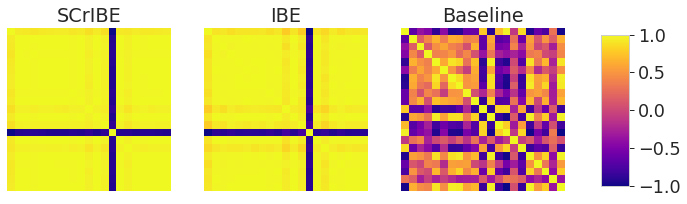

In [20]:
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2.0, rc={"lines.linewidth": 2.5})


s_im = make_grid(s_lt.cor[-8:-7].unsqueeze(1), nrow=3, padding=2, pad_value=-255)[0,:,:].numpy()
i_im = make_grid(i_lt.cor[-8:-7].unsqueeze(1), nrow=3, padding=2, pad_value=-255)[0,:,:].numpy()
n_im = make_grid(n_lt.cor[-8:-7].unsqueeze(1), nrow=3, padding=2, pad_value=-255)[0,:,:].numpy()

s_mn = s_lt.mean.numpy()
i_mn = i_lt.mean.numpy()
n_mn = n_lt.mean.numpy()

_mn, _mx = -1,1

fig, ax = plt.subplots(1,3, figsize=(10,3))

ax[0].set_title('SCrIBE')
im1 = ax[0].imshow(s_im, vmin=_mn, vmax=_mx, cmap='plasma')

ax[1].set_title('IBE')
im2 = ax[1].imshow(i_im, vmin=_mn, vmax=_mx, cmap='plasma')

ax[2].set_title('Baseline')
im3 = ax[2].imshow(n_im, vmin=_mn, vmax=_mx, cmap='plasma')

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
cbar_ax = fig.add_axes([0.95, 0.15, 0.04, 0.70])
fig.colorbar(im3, cax=cbar_ax)
plt.show()

## Analysis

### Generate Visual Results

In [21]:
from joint_transforms import FixedResize

class ImViewLblTransform(object):
    def __init__(self):
        im_tran =  [
            transforms.ToTensor(), 
            transforms.Normalize(**MEAN_STD)  
        ]
        
        self.joint_train = FixedResize(224)
        self.img_transform = transforms.Compose(im_tran)
            
    def __call__(self, img, lbl):
        img, lbl = self.joint_train(img, lbl)
        img = self.img_transform(img)
        lbl = np.array(lbl).astype(np.float32)
        lbl = torch.from_numpy(lbl).float()
        return img, lbl

voc_val = VOCSegmentation(root='/data/datasets/', 
                          transforms=ImViewLblTransform(), 
                          image_set='val')

val_set_list = []
for im, lbl in list(voc_val):
    im = im*torch.tensor(MEAN_STD['std']).reshape(3,1,1)+torch.tensor(MEAN_STD['mean']).reshape(3,1,1)
    val_set_list.append(im)

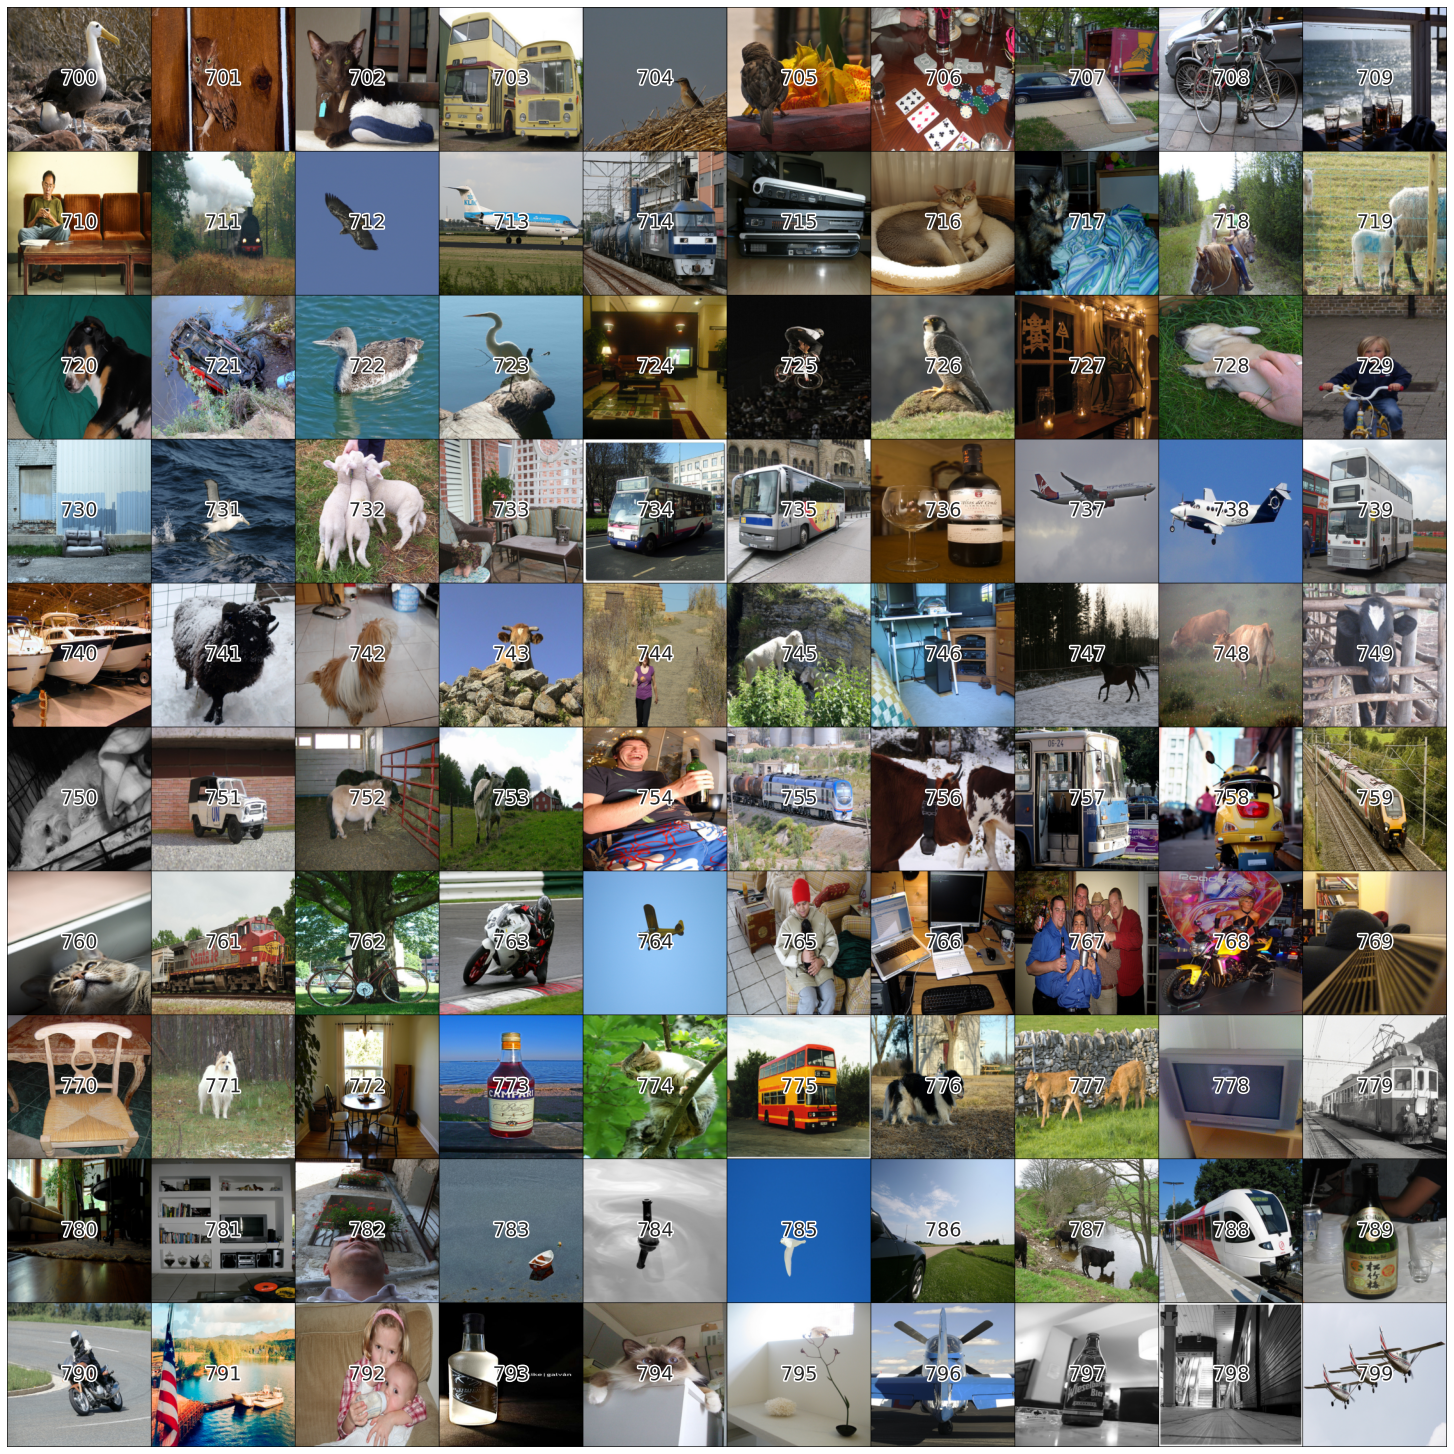

In [22]:
#@title ValSet Explorer
delta =  700#@param {type:"integer"}
from torchvision.utils import make_grid
import matplotlib.patheffects as path_effects
img = make_grid(torch.stack(val_set_list[0+delta:100+delta]), nrow=10, padding=1).permute(1,2,0).detach().cpu().numpy()

fig = plt.figure(figsize=(20,20))
ax = fig.add_axes([0,0,1,1])
plt.imshow(img)
n = 0
for i in range(10):
    for j in range(10):
        txt = ax.text(.05+j/10, .95-i/10,
                 n+delta, 
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=ax.transAxes
                )
        txt.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                       path_effects.Normal()])
        n += 1
plt.axis('off')
plt.show()



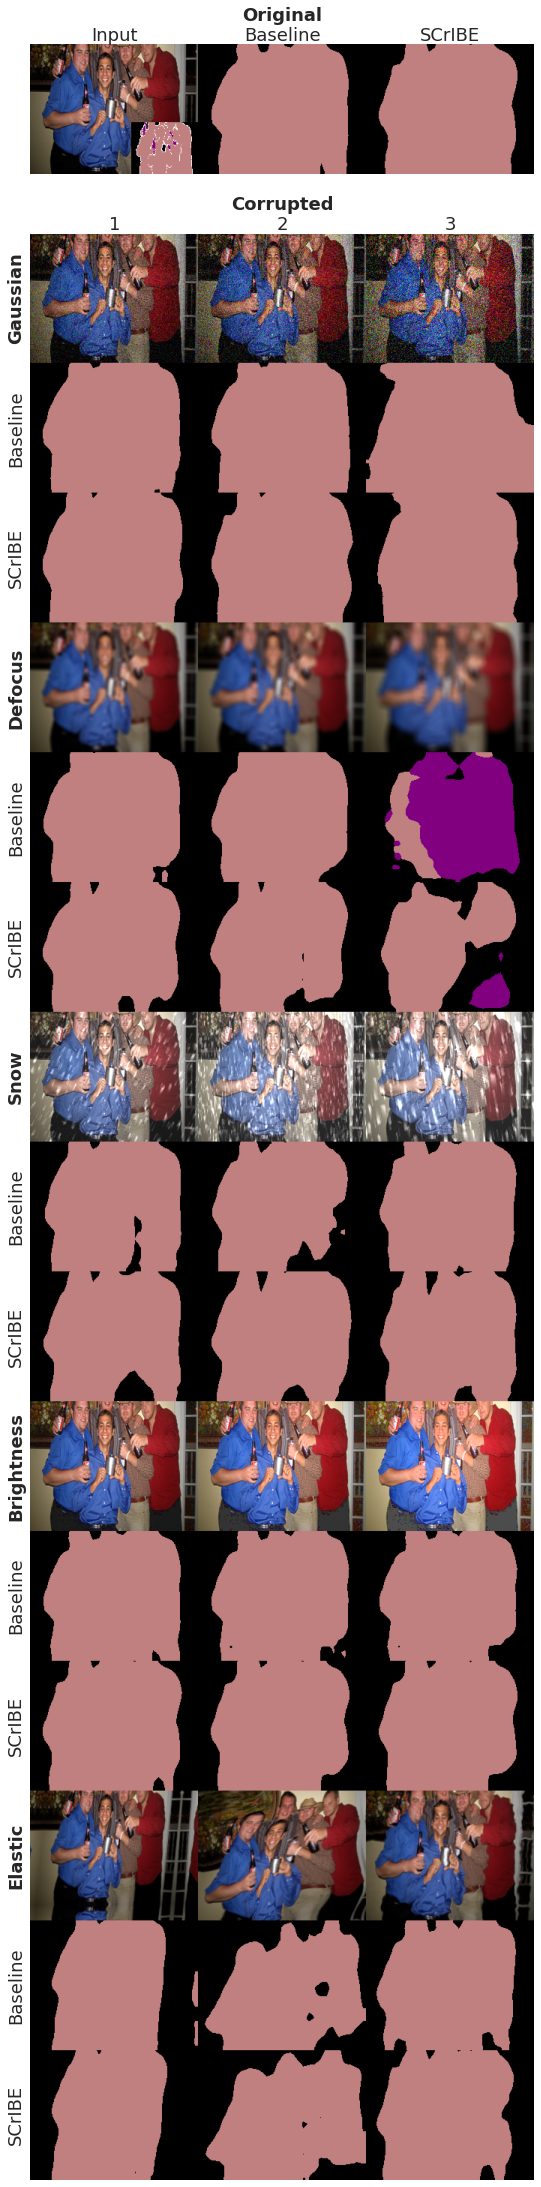

In [23]:
dataset_index =  767#@param {type:"number"}
crop_top =  50#@param {type:"number"}
crop_bot =  1#@param {type:"number"}
Dataset = "val" #@param ["val", "train"]

from torchvision.utils import make_grid
from matplotlib.figure import figaspect
preds=[]
scribe_model = scribe_model.to(0)
no_scribe_model = no_scribe_model.to(1)
scribe_model.eval()
no_scribe_model.eval()
corr_disp_list = [0,3,7,10,12]
sv_list = range(0,4)
for cn in corr_disp_list:
    for sv in sv_list:
        voc_val = VOCSegmentation(root='/data/datasets/', 
                                  transforms=ImLblCorruptTransform(sv,cn), 
                                  image_set=Dataset)
 
        im, lbl = voc_val[dataset_index]
        c,h,w = im.shape
        output = scribe_model(im.unsqueeze(0).to(0))
        pred = output.argmax(1).cpu().squeeze().numpy()
        pred = torch.tensor(colorize_voc_label(pred)[:,:,:3]).float().permute(2,0,1)
        
        noutput = no_scribe_model(im.unsqueeze(0).to(1))
        npred = noutput.argmax(1).cpu().squeeze().numpy()
        npred = torch.tensor(colorize_voc_label(npred)[:,:,:3]).float().permute(2,0,1)
        lbl= torch.tensor(colorize_voc_label(lbl)[:,:,:3]).float().permute(2,0,1)
        
        im = im*torch.tensor(MEAN_STD['std']).reshape(3,1,1)+torch.tensor(MEAN_STD['mean']).reshape(3,1,1)
        im = im[:,crop_top:-crop_bot,:]
        pred = pred[:,crop_top:-crop_bot,:]
        npred = npred[:,crop_top:-crop_bot,:]
        lbl = lbl[:,crop_top:-crop_bot,:]
        imp = torch.cat([im,npred,pred],1)
        preds.append(imp.detach().cpu())
        if sv==0:
            or_img = im.permute(1,2,0).detach().cpu().numpy()
            or_lbl = lbl.permute(1,2,0).detach().cpu().numpy()
            sm_lbl = nn.functional.interpolate(lbl.unsqueeze(0), scale_factor=.4).squeeze()
            sl_c,sl_h,sl_w = sm_lbl.shape
            oi_c,oi_h,oi_w = lbl.shape
            mod_img = im.clone()
            mod_img[:,oi_h-sl_h:,oi_w-sl_w:] = sm_lbl
            pristine = make_grid(torch.stack([mod_img,npred,pred]),nrow=3,padding=0)
            pristine_ = pristine.permute(1,2,0).detach().cpu().numpy()
        
        
# Pristine
# Summary
preds = torch.stack(preds)
preds = make_grid(preds,nrow=len(sv_list),padding=0)
disp_im = preds.permute(1,2,0).numpy()[0:len(corr_disp_list)*h*3,1*w:]
d_h,d_w,_ = disp_im.shape
p_h,p_w,_ = pristine_.shape
p_w = d_w*3/(len(sv_list)-1)
p_h *= d_w/p_w
d_h /= 96
d_w /= 96
p_h /= 96
p_w /= 96
tot_h = (d_h+p_h)/0.7
tot_w = (d_w+p_w)/0.8
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(tot_w,tot_h))
ax_ = fig.add_axes([0.1,d_h/tot_h+0.12,0.8,p_h/tot_h])
ax_.axis('off')
ax_.imshow(pristine_)
ax_.text(1/(2*3)+1/3*0,1, 
         'Input', 
         horizontalalignment='center',
         verticalalignment='bottom',
         transform=ax_.transAxes
        )
ax_.text(1/(2*3)+1/3*1,1, 
         'Baseline', 
         horizontalalignment='center',
         verticalalignment='bottom',
         transform=ax_.transAxes
        )
ax_.text(1/(2*3)+1/3*1,1.15, 
         'Original', 
         horizontalalignment='center',
         verticalalignment='bottom',
         transform=ax_.transAxes,
         fontweight='bold'
        )
ax_.text(1/(2*3)+1/3*2,1, 
         'SCrIBE', 
         horizontalalignment='center',
         verticalalignment='bottom',
         transform=ax_.transAxes
        )
ax = fig.add_axes([0.1,0.1,0.8,d_h/tot_h])
ax.axis('off')
n_corr = len(corr_disp_list)
y_start = (1-1/(2*n_corr*3))
y_step = 1/(n_corr)
ax.imshow(disp_im)
for j, cn in enumerate(corr_disp_list):
    nm = corruption_tuple[cn].__name__.split('_')[0].capitalize()
    ax.text(-.01,y_start-y_step*j, nm, 
             horizontalalignment='right',
             verticalalignment='center',
             transform=ax.transAxes,
            rotation=90,
             fontweight='bold'
            )
    ax.text(-.01,y_start-y_step/3-y_step*j, 
            'Baseline', 
             horizontalalignment='right',
             verticalalignment='center',
            rotation=90,
             transform=ax.transAxes
            )
    ax.text(-.01,y_start-2*y_step/3-y_step*j, 
            'SCrIBE', 
             horizontalalignment='right',
             verticalalignment='center',
            rotation=90,
             transform=ax.transAxes
            )
x_start = 1/(2*(len(sv_list)-1))
x_step = 1/(len(sv_list)-1)
for sv in sv_list[1:]:
    ax.text(x_start+x_step*(sv-1),1, 
             sv, 
             horizontalalignment='center',
             verticalalignment='bottom',
             transform=ax.transAxes
            )
    
ax.text(x_start+x_step*(2-1),1.01, 
         'Corrupted', 
         horizontalalignment='center',
         verticalalignment='bottom',
         transform=ax.transAxes,
         fontweight='bold'
        )
    
display()


### Plot

<AxesSubplot:xlabel='Severity', ylabel='mIOU'>

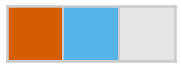

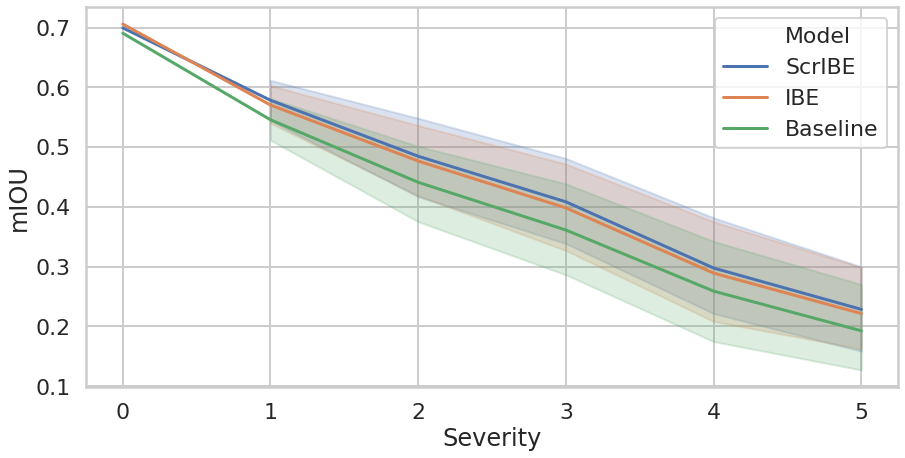

In [24]:
import matplotlib as mpl
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
sns.set_context("poster")
df = pd.read_pickle('data/DistCombined.pkl')

rgbs = [(213/255, 94/255, 0/255), (86/255, 180/255, 233/255), (.9, .9, .9)]

cblind = [mpl.colors.to_hex(r) for r in rgbs]
cblind_gray = [mpl.colors.to_hex(
    mpl.colors.hsv_to_rgb(mpl.colors.rgb_to_hsv(r) * (1,0,1)))
    for r in rgbs]

pal = sns.color_palette(cblind)
sns.palplot(pal)
fig, ax = plt.subplots(figsize=(9*1.618,7))
sns.lineplot(x='Severity', y='mIOU', data=df, ax=ax, hue='Model')
#plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)

In [72]:
import skvideo.io  
video = 'walkAS.mp4'
videodata = skvideo.io.vread(f'example_videos/{video}')  
print(videodata.shape)


(1818, 720, 1280, 3)


In [56]:
videodata = np.concatenate([videodata]*6)

In [73]:
class ImCorruptTransform(object):
    def __init__(self, severity, corruption_number, red_size):
        corrupt_partial = partial(corrupt, severity=severity, corruption_number=corruption_number)
        self.transform = lambda sz: transforms.Compose(
            [
            np.array,
            corrupt_partial,
            Image.fromarray,
            transforms.Resize(sz),
            transforms.ToTensor(), 
            transforms.Normalize(**MEAN_STD),
            ]
        )
        if severity == 0:
            self.transform = lambda sz: transforms.Compose(
                [
                transforms.Resize(sz),
                transforms.ToTensor(), 
                transforms.Normalize(**MEAN_STD)   
                ]
            )
        self.red_size = red_size
        
            
    def __call__(self, img):
        img = Image.fromarray(img)
        img = img.resize(self.red_size)
        W,H = img.size
        sz = (H,W)
        img = img.resize((224,224),Image.BILINEAR)
        img = self.transform(sz)(img)
        return img
    


In [27]:
print(corruption_tuple[0].__name__)

gaussian_noise


In [74]:

ns_preds = []
s_preds = []
ims = []
corr_ims = []
corr_txts = []
switch = videodata.shape[0]//13
sv = 0
cn =0 


pbar = tqdm(enumerate(videodata), total=videodata.shape[0])
for k, im in pbar:
    if k%switch==0 and k!=0:
        sv = 2
        cn += 1
        if cn == 8:
            cn += 1
        if cn == 12:
            sv = 3
    if cn > 0:
        corr_txts.append(corruption_tuple[cn].__name__)
    else:
        corr_txts.append('None')
    pbar.set_description(corr_txts[-1])
    transform = ImCorruptTransform(sv,cn, (480,270))
    ims.append(np.array(transforms.Resize(270)(Image.fromarray(im))))
    im = transform(im)
    corr_ims.append(im.permute([1,2,0]).numpy())
    im = im.unsqueeze(0)
    
    s_pred = scribe_model(im.to(0))
    s_pred = s_pred.argmax(1).cpu().numpy()
    s_c_out = colorize_voc_label(s_pred)
    s_preds.append(s_c_out[:,:,:,:3])
    
    ns_pred = no_scribe_model(im.to(1))
    ns_pred = ns_pred.argmax(1).cpu().numpy()
    ns_c_out = colorize_voc_label(ns_pred)
    ns_preds.append(ns_c_out[:,:,:,:3])
ns_preds = np.concatenate(ns_preds)
s_preds = np.concatenate(s_preds)

(270, 480, 3) (270, 480, 3)


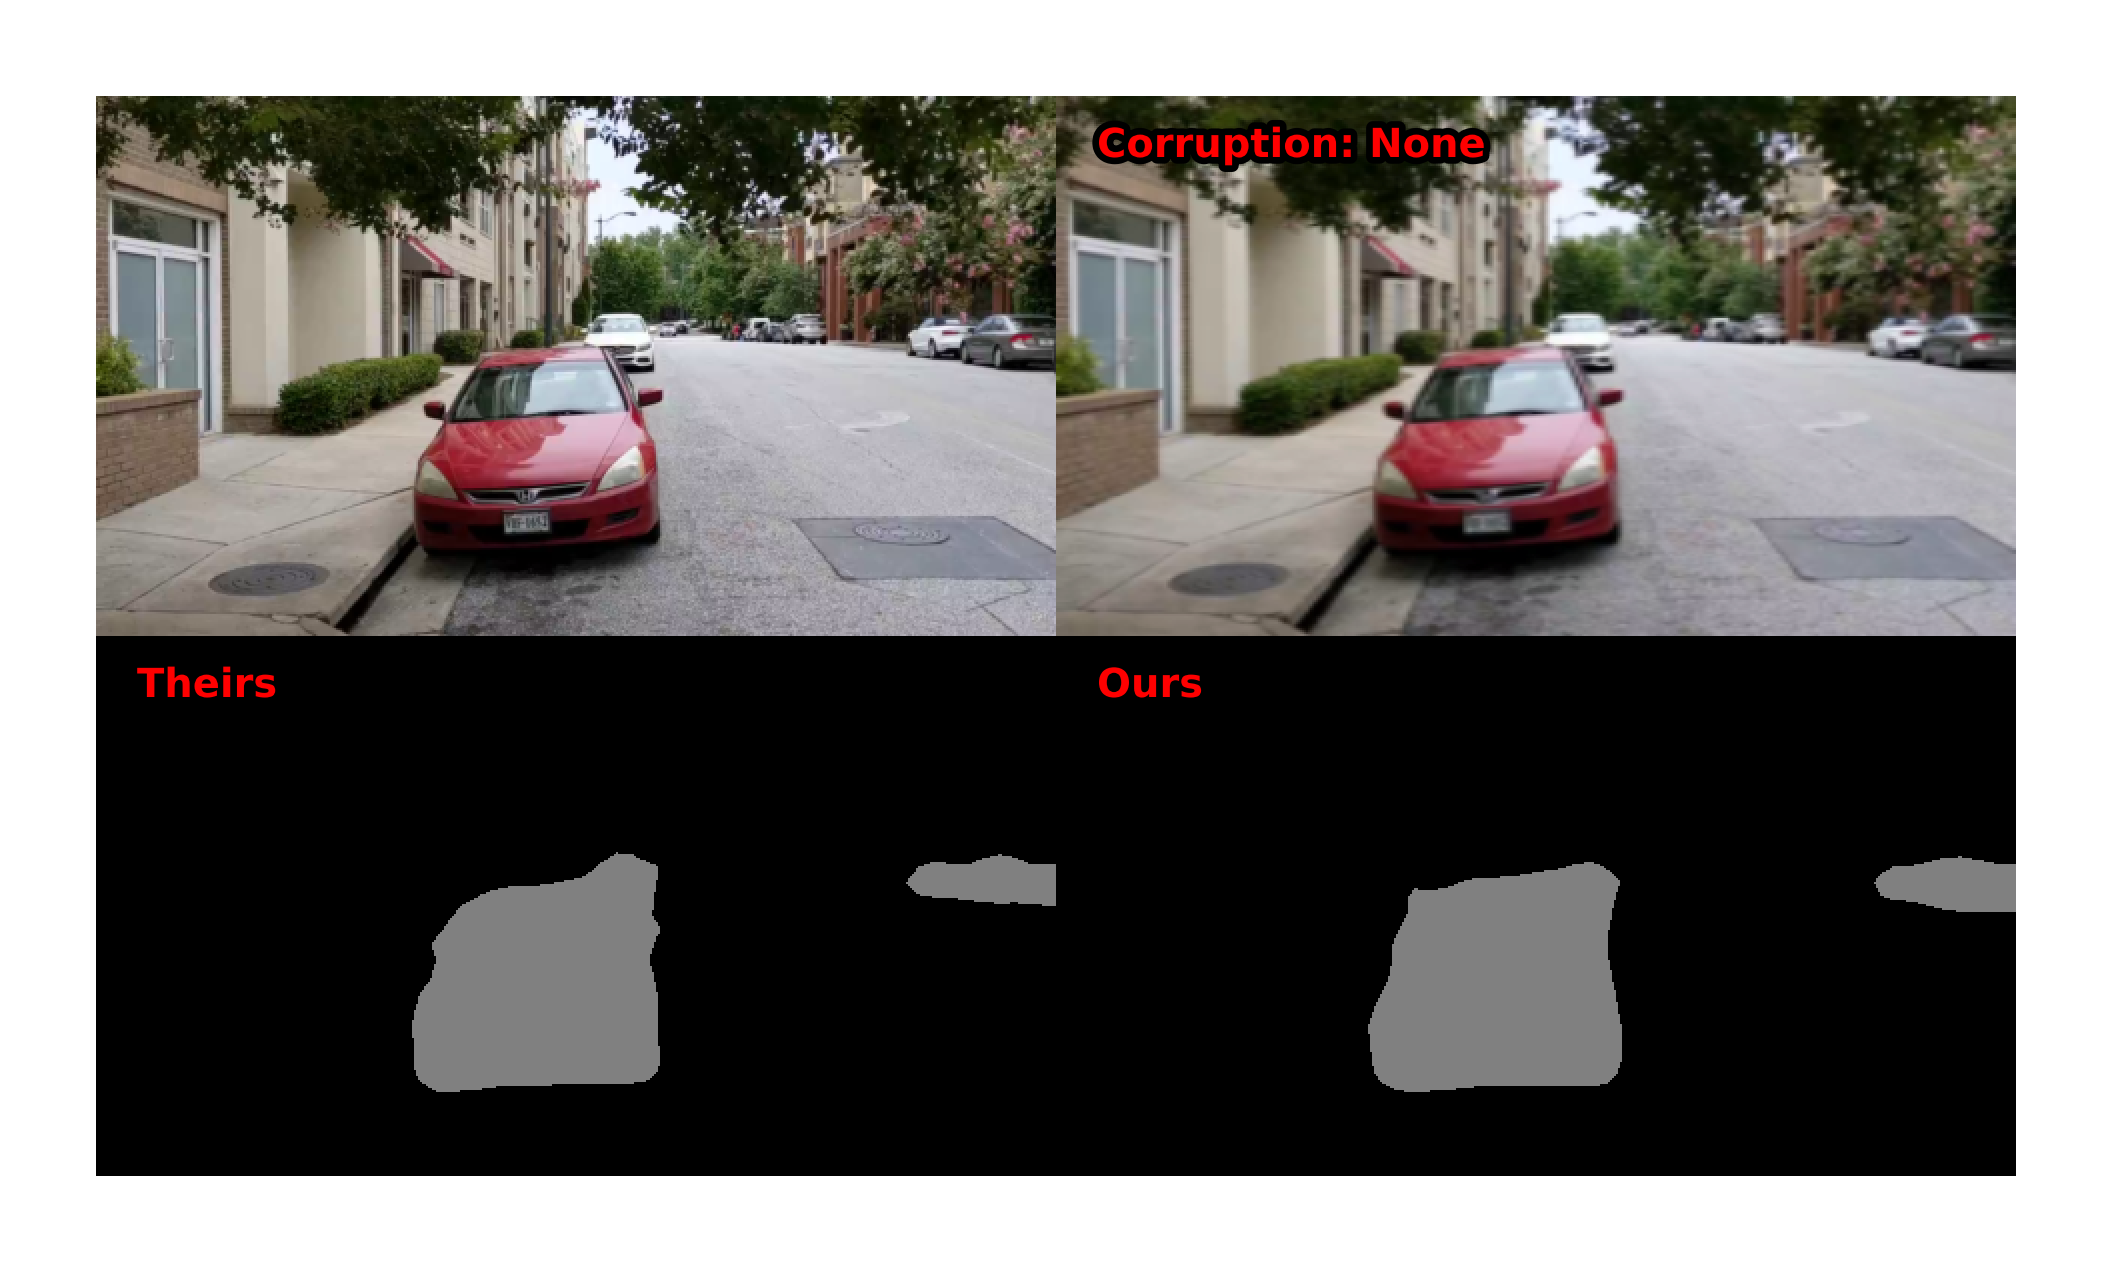

In [75]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='html5')
print(ims[0].shape, corr_ims[0].shape)
def join_ex(im,corrim,ns_pred,s_pred):
    im = im/255.0
    corrim = corrim*MEAN_STD['std']+MEAN_STD['mean']
    corrim = np.clip(corrim,0,1)
    top = np.concatenate([im, corrim],1)
    bot = np.concatenate([ns_pred, s_pred],1)
    return np.concatenate([top,bot], 0)
    

my_dpi = 960
fig, ax = plt.subplots(1,figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)
vis = ax.imshow(join_ex(ims[0],corr_ims[0], ns_preds[0], s_preds[0]))
corrtxt = ax.text(500, 30, f'Corruption: None', fontsize=3, color='red', fontweight='bold')
corrtxt.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()]) 
theirs = ax.text(20, 300, f'Theirs', fontsize=3, color='red', fontweight='bold')
theirs.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()]) 
ours = ax.text(500, 300, f'Ours', fontsize=3, color='red', fontweight='bold')
ours.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()]) 

def animate(i):
    corrtxt.set_text(f'Corruption: {corr_txts[i]}')
    vis.set_array(join_ex(ims[i],corr_ims[i], ns_preds[i], s_preds[i]))
    return [vis]

def init():
    vis.set_array(join_ex(ims[0],corr_ims[0], ns_preds[0], s_preds[0]))
    return [vis]
    
fig.tight_layout()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.set_axis_off()
ani = animation.FuncAnimation(fig, animate, frames=s_preds.shape[0], interval=30, blit=True, init_func=init)
    

In [76]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=18000)
ani.save(f'example_videos/scribe_pred_{video}', writer=writer)